# Density Control (0.25) & fcc lattice, v 1.0 on cpu

rho=  0.25
T=  0.7
dt=  0.001
cell sides=  4.641588833612778 0.9283177667225557 0.9283177667225557
repeats=  4 15 15
particles= 900
output files: trajectory_rho_0.25_T_0.7.gsd , log_rho_0.25_T_0.7.log
HOOMD-blue v2.3.1-1-gb7f98d0 CUDA (8.0) DOUBLE HPMC_MIXED MPI SSE SSE2 SSE3 
Compiled: 06/07/18
Copyright 2009-2018 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, C D Lorenz, and A Travesset. "General purpose molecular dynamics
  simulations fully implemented on graphics processing units", Journal of
  Computational Physics 227 (2008) 5342--5359
* J Glaser, T D Nguyen, J A Anderson, P Liu, F Spiga, J A Millan, D C Morse, and
  S C Glotzer. "Strong scaling of general-purpose molecular dynamics simulations
  on GPUs", Computer Physics Communications 192 (2015) 97--107
-----
notice(2): NVIDIA driver not installed or is too old, ignoring any GPUs in the system.
HOOMD-blue is running on the CPU
notice(2): Group "all" create

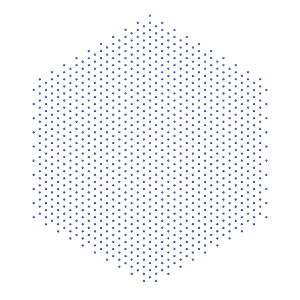

In [1]:
# import hoomd packages and molecular dynamics component

from __future__ import division
import hoomd
import hoomd.md
import ex_render


#--- Initialization
# define parameters for this simulation

gb_kappa = 5.0;
gb_parallel_semiaxis = gb_kappa/2.0;
gb_perpendicular_semiaxis = 0.50;
gb_epsilon =1.0;
gb_r_cut = 6.5;

density= 0.25;
temperature= 0.70; 
md_time_step = 0.001

print("rho= ", density)
print("T= ", temperature);
print("dt= ", md_time_step);

unit_cell_side_3 = 1.0/(gb_kappa*density)**(1./3.);
unit_cell_side_2 = unit_cell_side_3
unit_cell_side_1 = gb_kappa*unit_cell_side_3;

unit_cell_side = 4/(density**(1./3.))

n_replicates = 10

n_x = 4;
n_y = 15;
n_z = n_y;

n_xyz = n_x * n_y * n_z;

print("cell sides= ", unit_cell_side_1, unit_cell_side_2, unit_cell_side_3);
print("repeats= "   , n_x, n_y, n_z);
print("particles="  , n_xyz);

log_file= "log_rho_" + str(density) + "_T_" + str(temperature) + ".log";
log_period = 1e3;

trajectory_file= "trajectory_rho_" + str(density) + "_T_" + str(temperature) + ".gsd";
trajectory_period = 1e3;

print("output files:", trajectory_file, ",", log_file)


                                   # ----- Begin hoomd code ----

    
# ----- System initialization
# initialize execution context (automatic selection between GPU and CPU)

hoomd.context.initialize("")

# initialize a fcc cell with a single particle, then replicate it as needed

fcc = hoomd.lattice.fcc(a = unit_cell_side, type_name='R') 

# Create lattice from previous unit cell

system = hoomd.init.create_lattice(unitcell = fcc, n = n_replicates);

# Calculate the density

volume = (unit_cell_side*n_replicates)**3
mass_test = (4*n_replicates)**3
density = mass_test/volume
print("The density is" ,density)

# Take a snapshot from the previous lattice

ex_render.render_sphere_frame(system.take_snapshot())

notice(2): constrain.rigid(): Creating 4000 rigid bodies (adding 16000 particles)


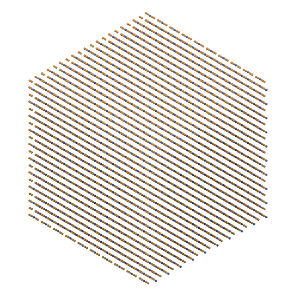

In [2]:
# Create the Rigid bodies adding particles
system.particles.types.add('A');
rigid = hoomd.md.constrain.rigid();
rigid.set_param('R', 
                types=['A']*4,
                positions=[(-2,0,0),(-1,0,0),
                           (1,0,0),(2,0,0)]);

rigid.create_bodies()
ex_render.render_sphere_frame(system.take_snapshot())

In [3]:
#--- Define interactions

# Choose the cell-list structure to create the neighbor lists
nl = hoomd.md.nlist.cell()

lj = hoomd.md.pair.lj(r_cut=2**(1/6), nlist=nl)
lj.set_params(mode='shift')

lj.pair_coeff.set(['R', 'A'], ['R', 'A'], epsilon=1.0, sigma=1.0)

#--- Select integrator

# Choose mode standard with a time step of 0.005
hoomd.md.integrate.mode_standard(dt=md_time_step)

rigid = hoomd.group.rigid_center();
#hoomd.md.integrate.langevin(group=rigid, kT=1.0, seed=42);

integrator = hoomd.md.integrate.nvt(group=rigid, kT=temperature,  tau=1.0)
integrator.randomize_velocities(seed=42)

notice(2): Group "rigid_center" created containing 4000 particles


In [4]:
#--- Select quantities and period to be logged

# The .log file is a text table
log1 = hoomd.analyze.log(filename=log_file,
                         quantities=['translational_kinetic_energy', 
                                   'rotational_kinetic_energy', 
                                   'potential_energy', 
                                   'temperature', 
                                   'pressure'],
                         period=log_period,
                         overwrite=True);

# The.gsd file is a binary trajectory in GSD format
hoomd.dump.gsd(trajectory_file, 
               period= trajectory_period, 
               group=hoomd.group.all(), 
               overwrite=True)

In [5]:
hoomd.run(1e4)

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 20000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: yes
** starting run **
Time 00:00:20 | Step 1472 / 10000 | TPS 147.138 | ETA 00:00:57


*Warning*: Integrator #0: Anisotropic integration requested, but no rotational degrees of freedom found for its group


Time 00:00:30 | Step 3027 / 10000 | TPS 155.42 | ETA 00:00:44
Time 00:00:40 | Step 4639 / 10000 | TPS 161.189 | ETA 00:00:33
Time 00:00:50 | Step 6273 / 10000 | TPS 163.339 | ETA 00:00:22
Time 00:01:00 | Step 7901 / 10000 | TPS 162.702 | ETA 00:00:12
Time 00:01:10 | Step 9483 / 10000 | TPS 158.116 | ETA 00:00:03
Time 00:01:13 | Step 10000 / 10000 | TPS 159.372 | ETA 00:00:00
Average TPS: 158.052
---------
-- Neighborlist stats:
121 normal updates / 100 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 5 / n_neigh_avg: 0.2673
shortest rebuild period: 47
-- Cell list stats:
Dimension: 41, 41, 41
n_min    : 0 / n_max: 5 / n_avg: 0.290187
** run complete **
